### Big one

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/updated_lightning/long")

In [3]:
s3_folder_filter="s3/*benchmark_e2e*"
scratch_folder_filter="scratch/*benchmark_e2e*"

Load the data

In [4]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 243.92it/s]


Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

Extract the GPU Utilization data

In [5]:
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 18811.66it/s]


In [6]:
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 16701.13it/s]


Get unique runs to loop through, and plot the results

### Plot function timelines for remote storage (AWS S3)

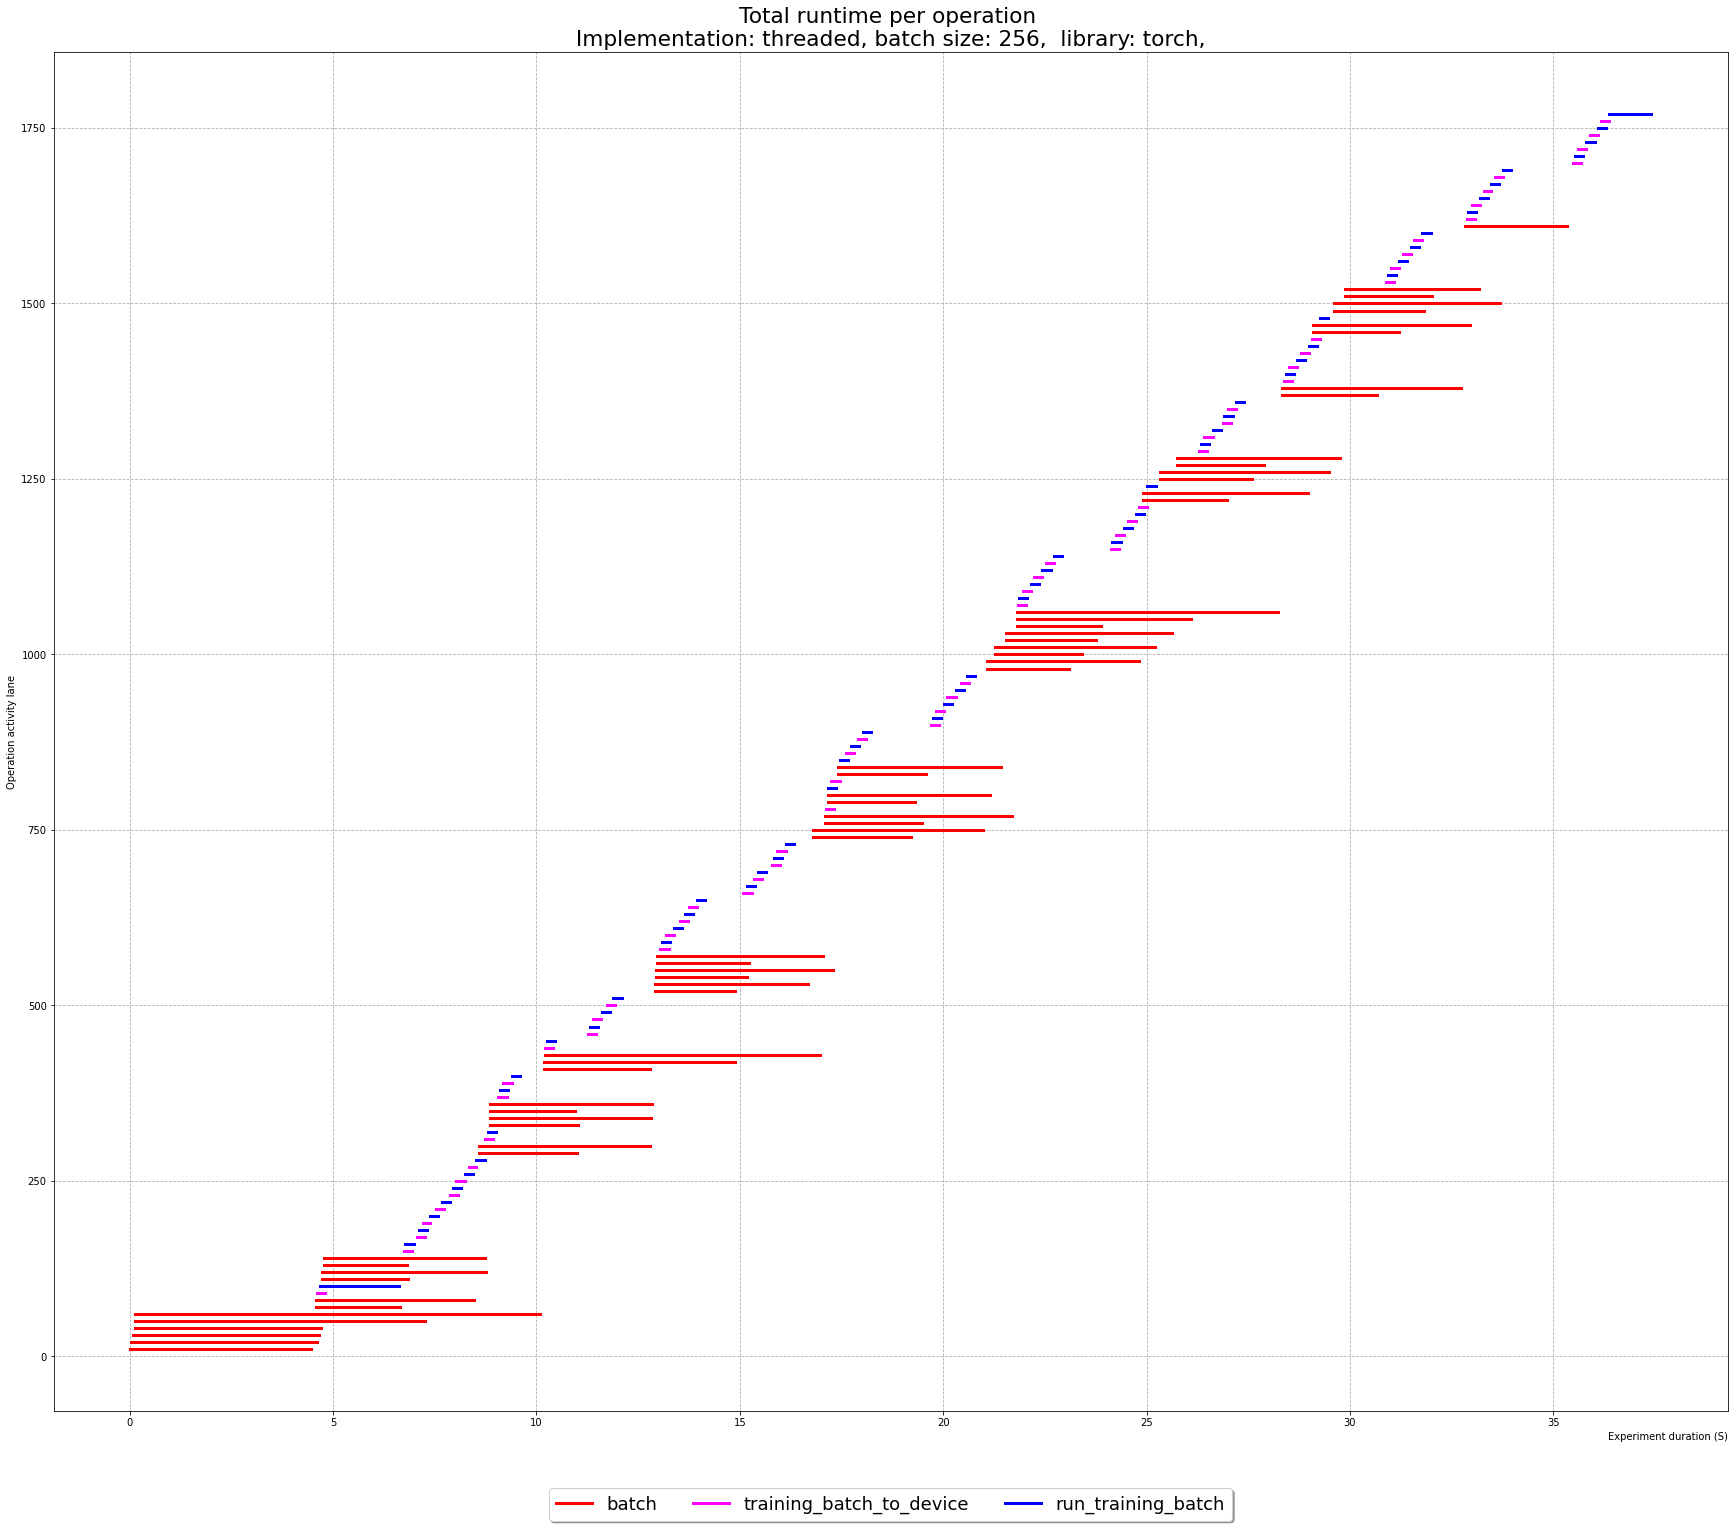

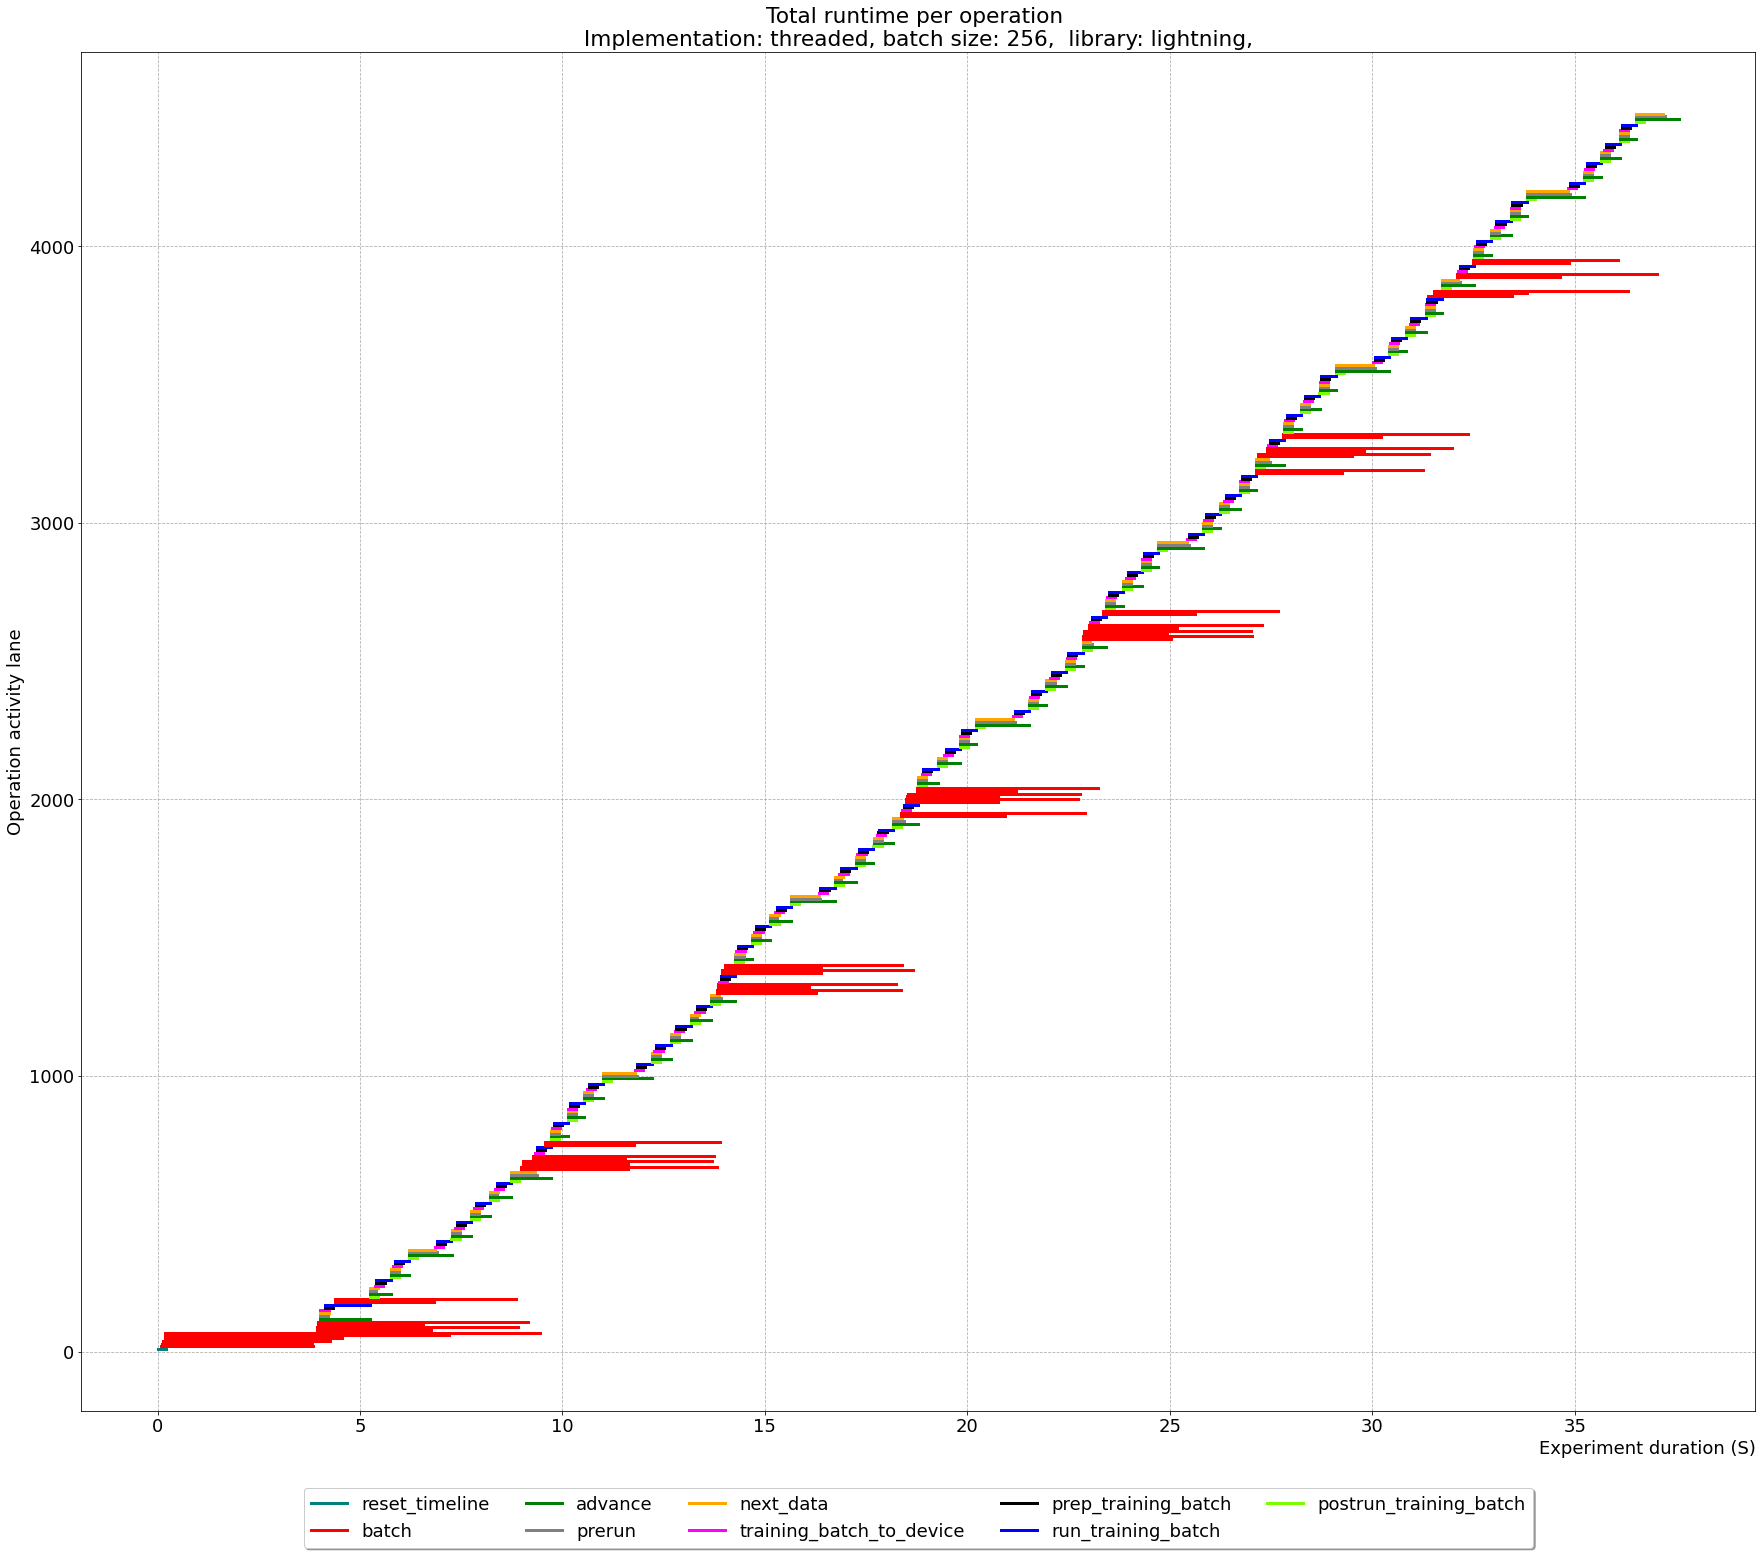

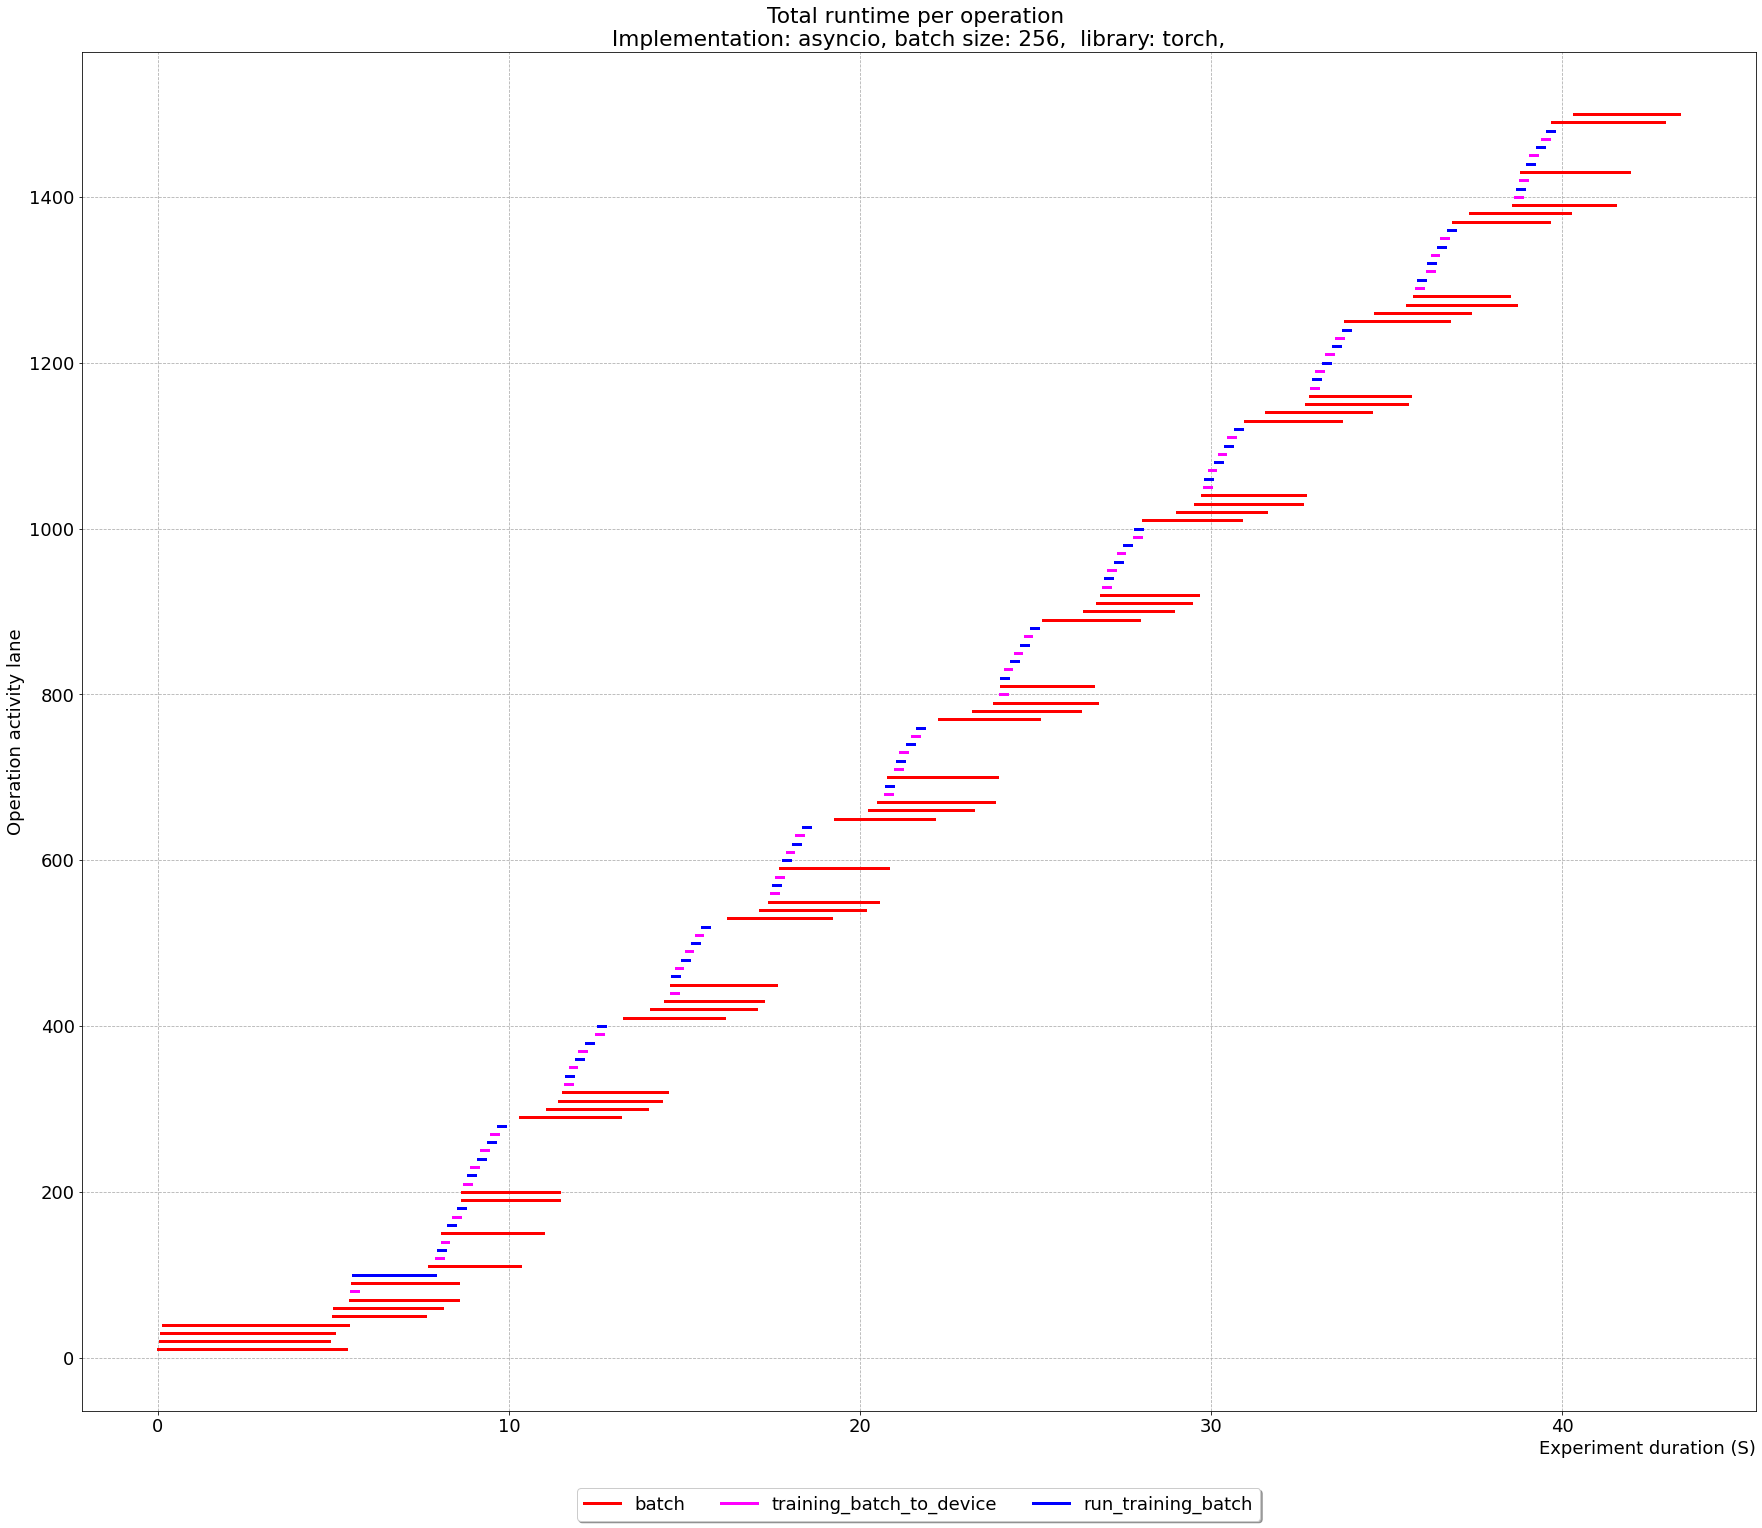

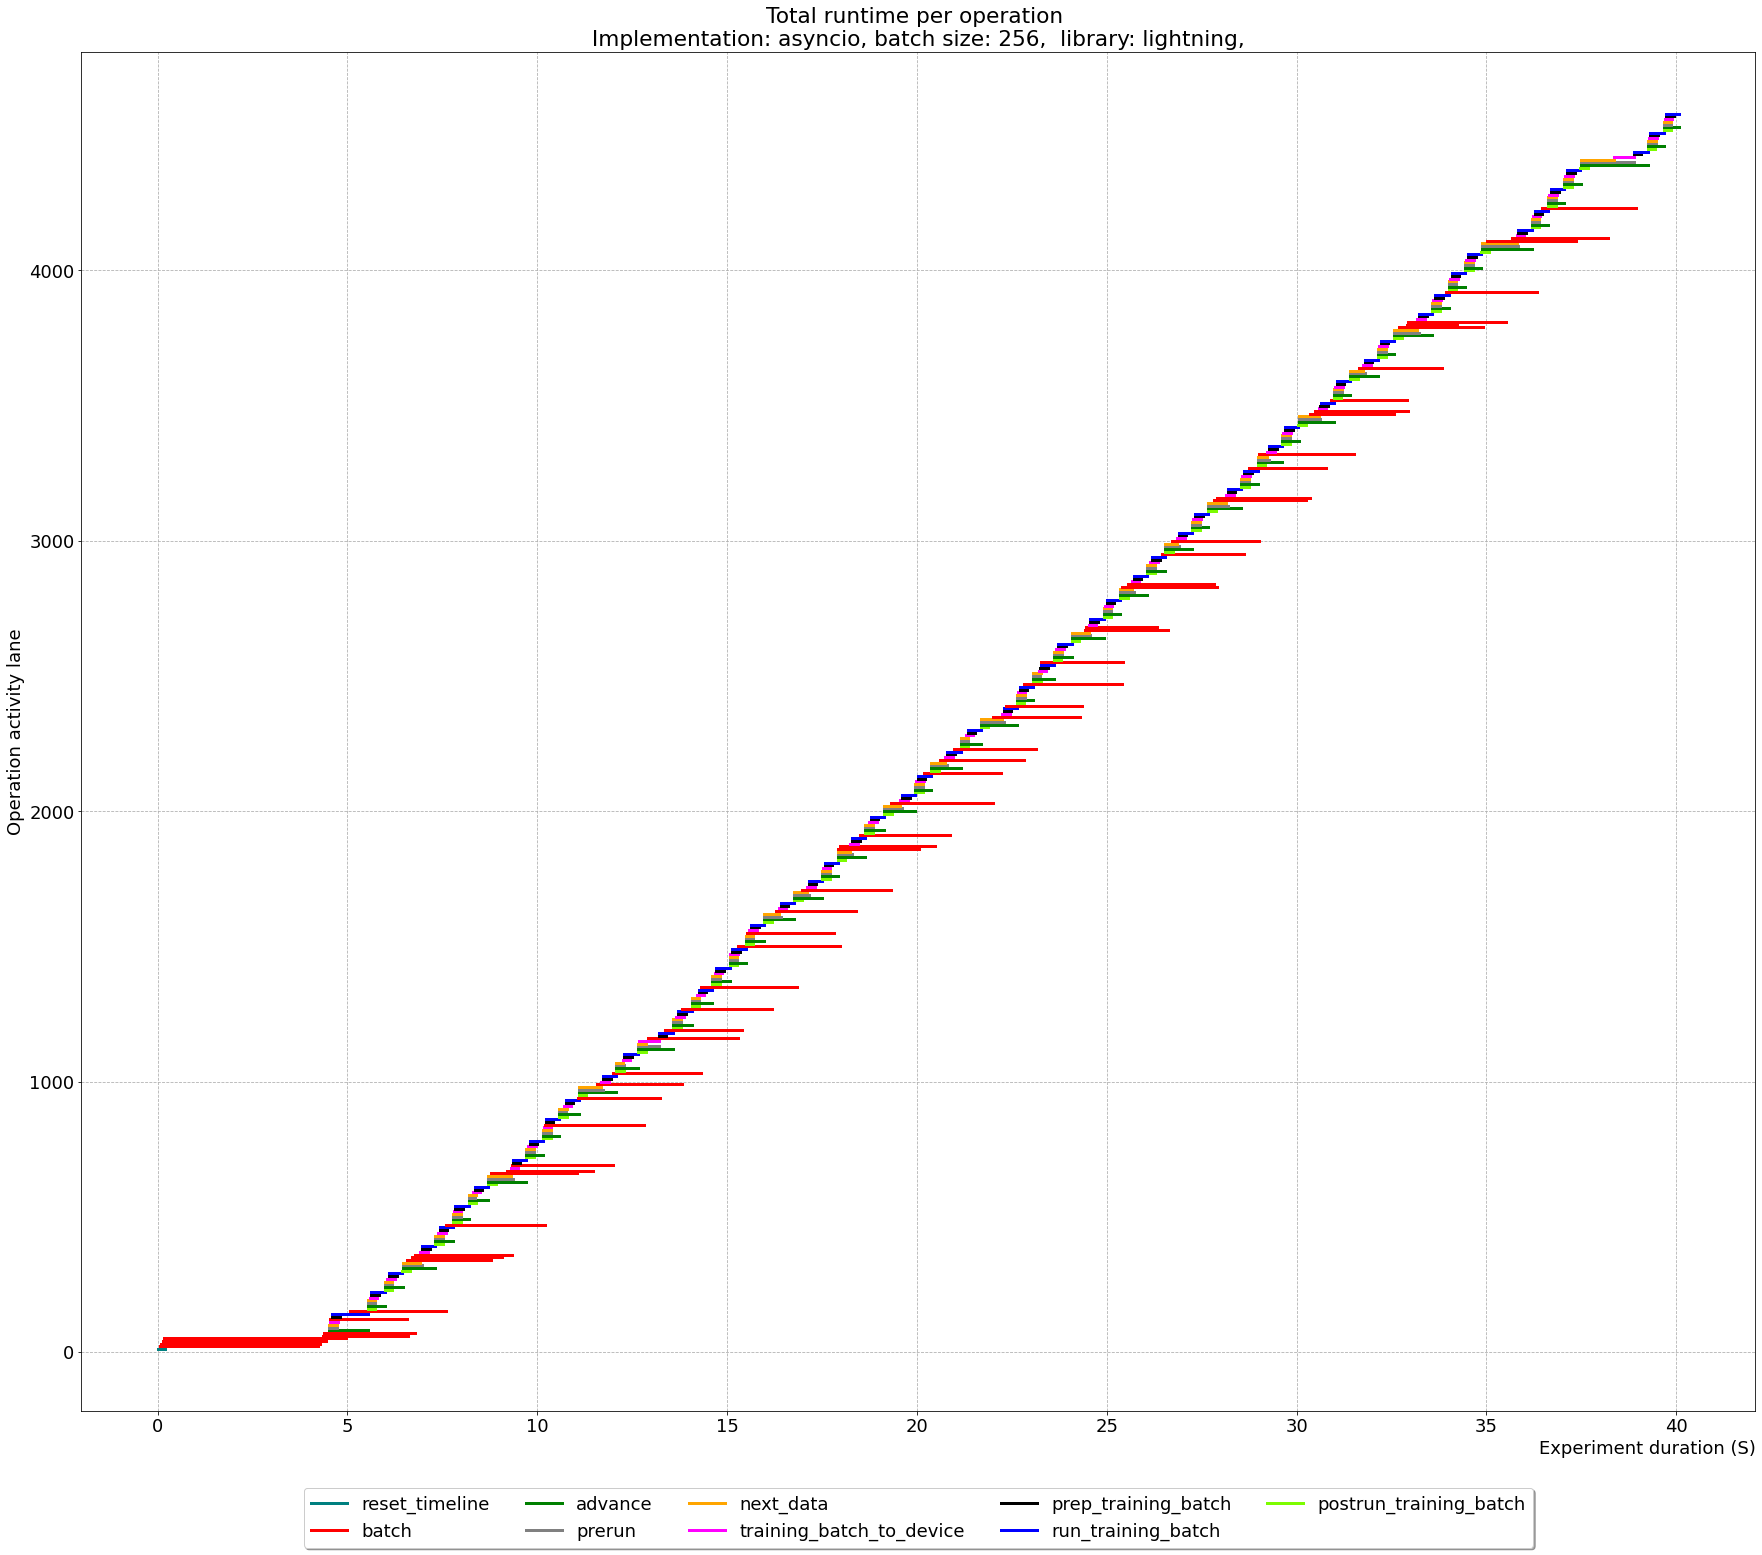

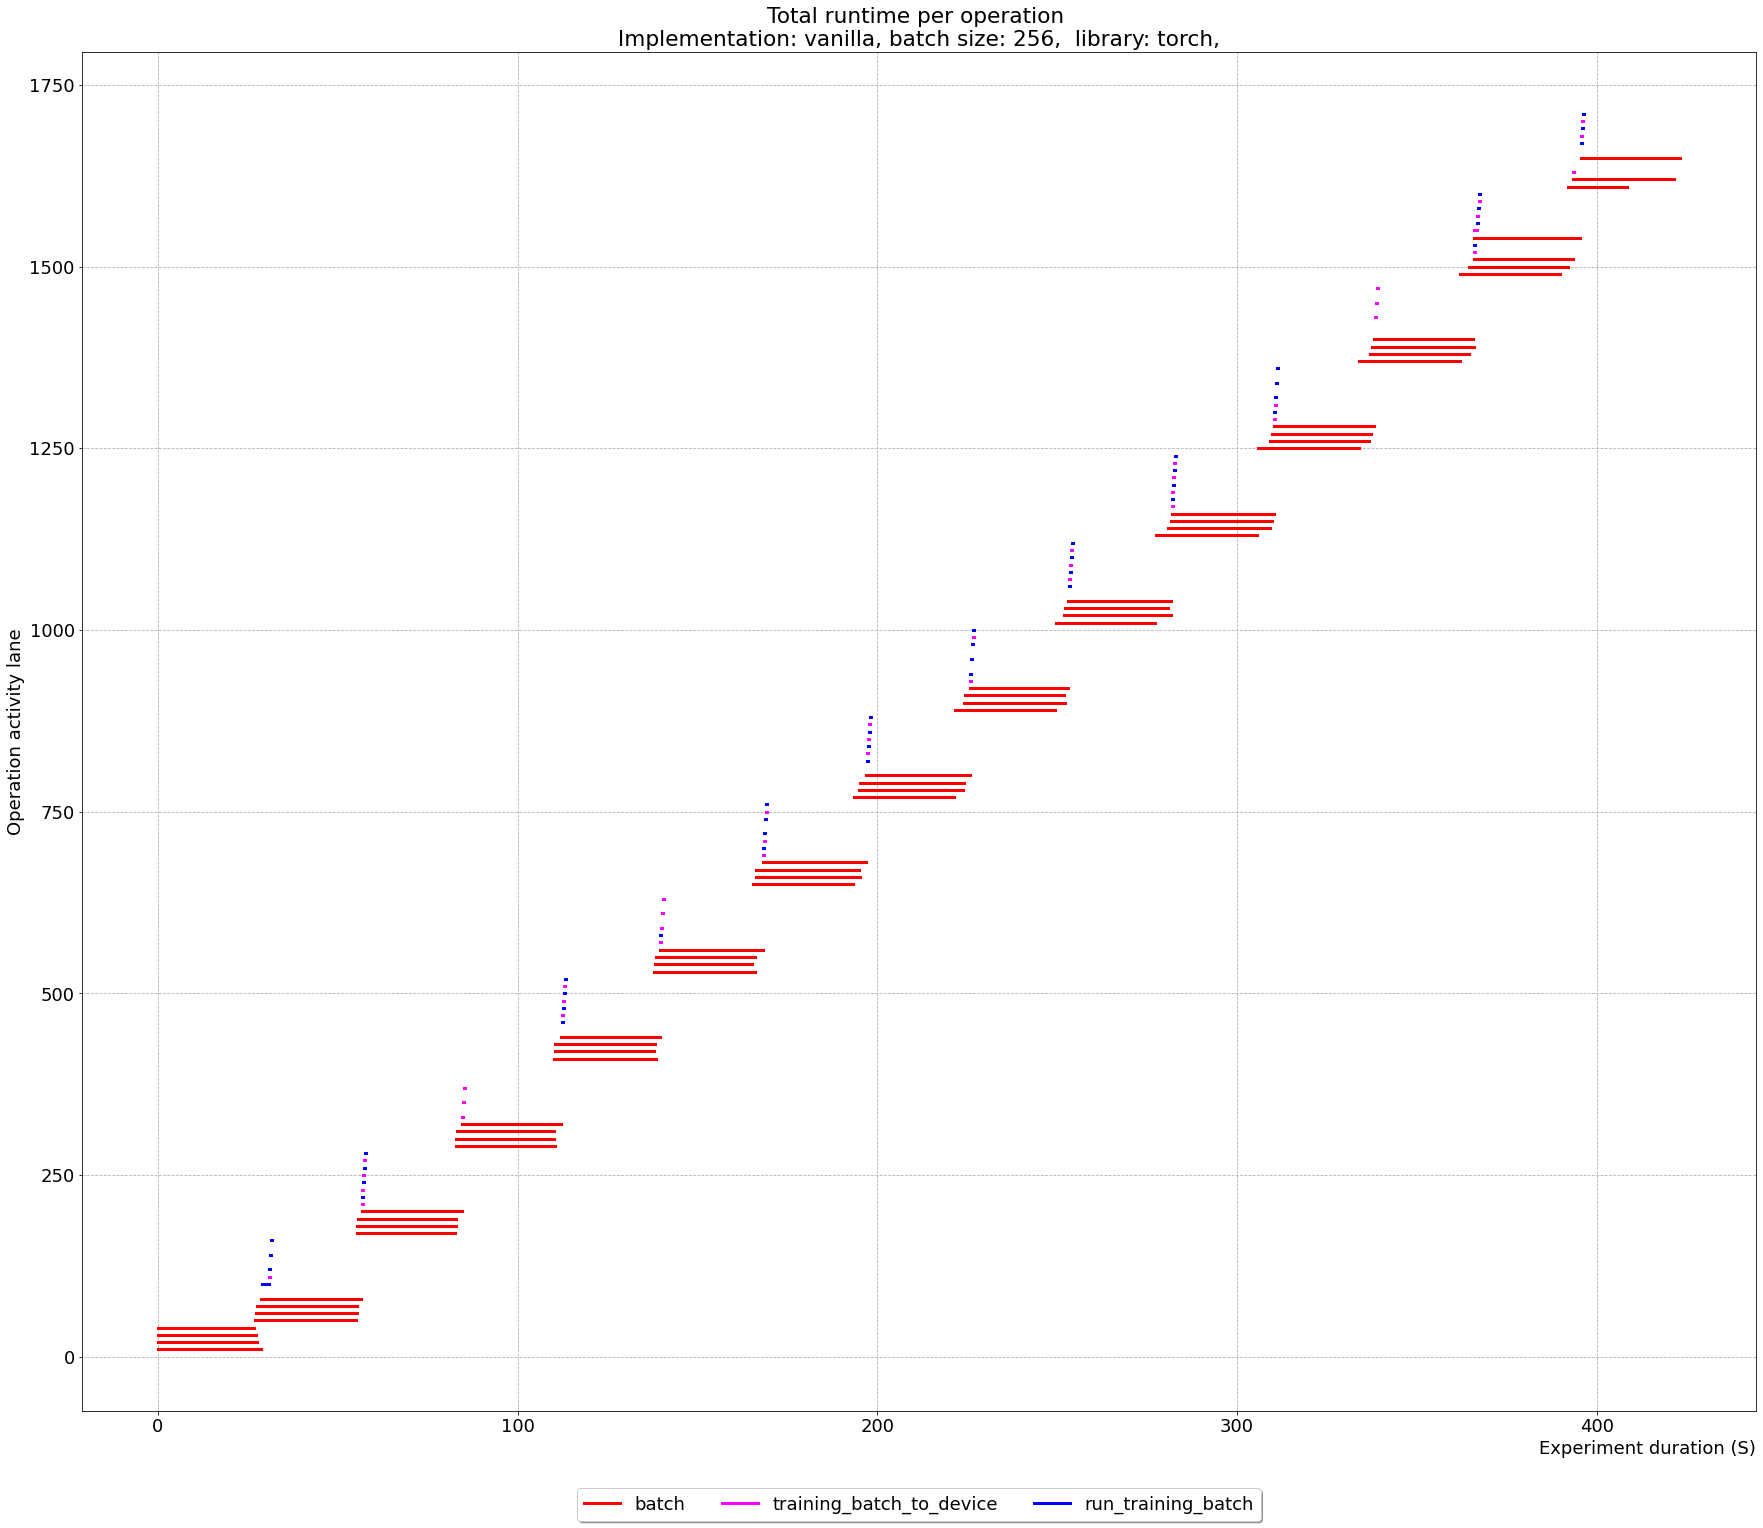

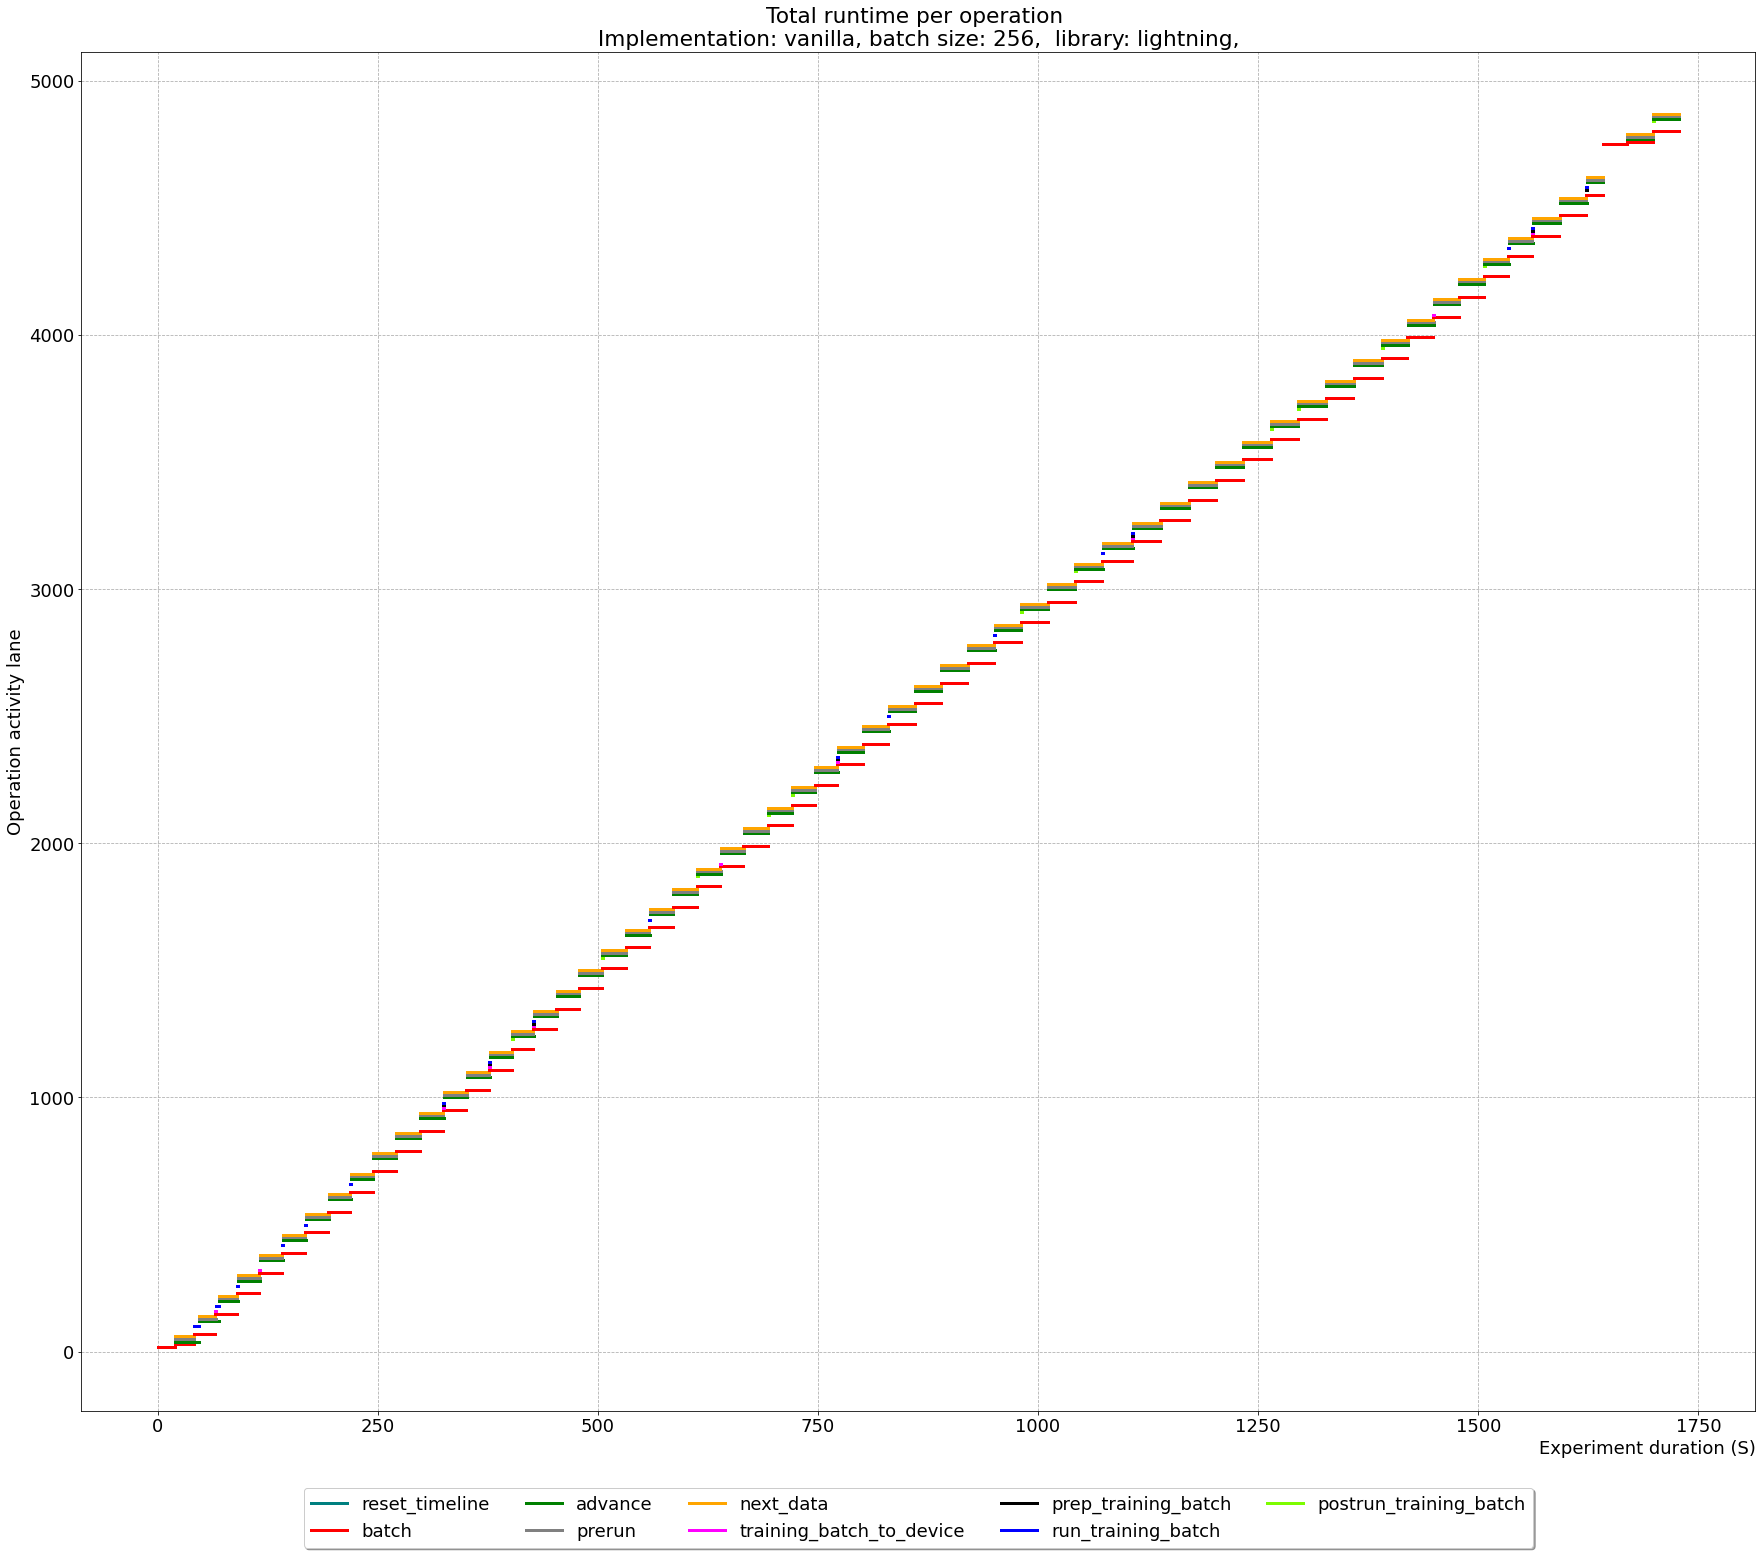

In [7]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
returns_s3 = []

for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
    result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, False, True, 2)
    result["run"]=run
    returns_s3.append(result)


### Plot function timelines for local storage

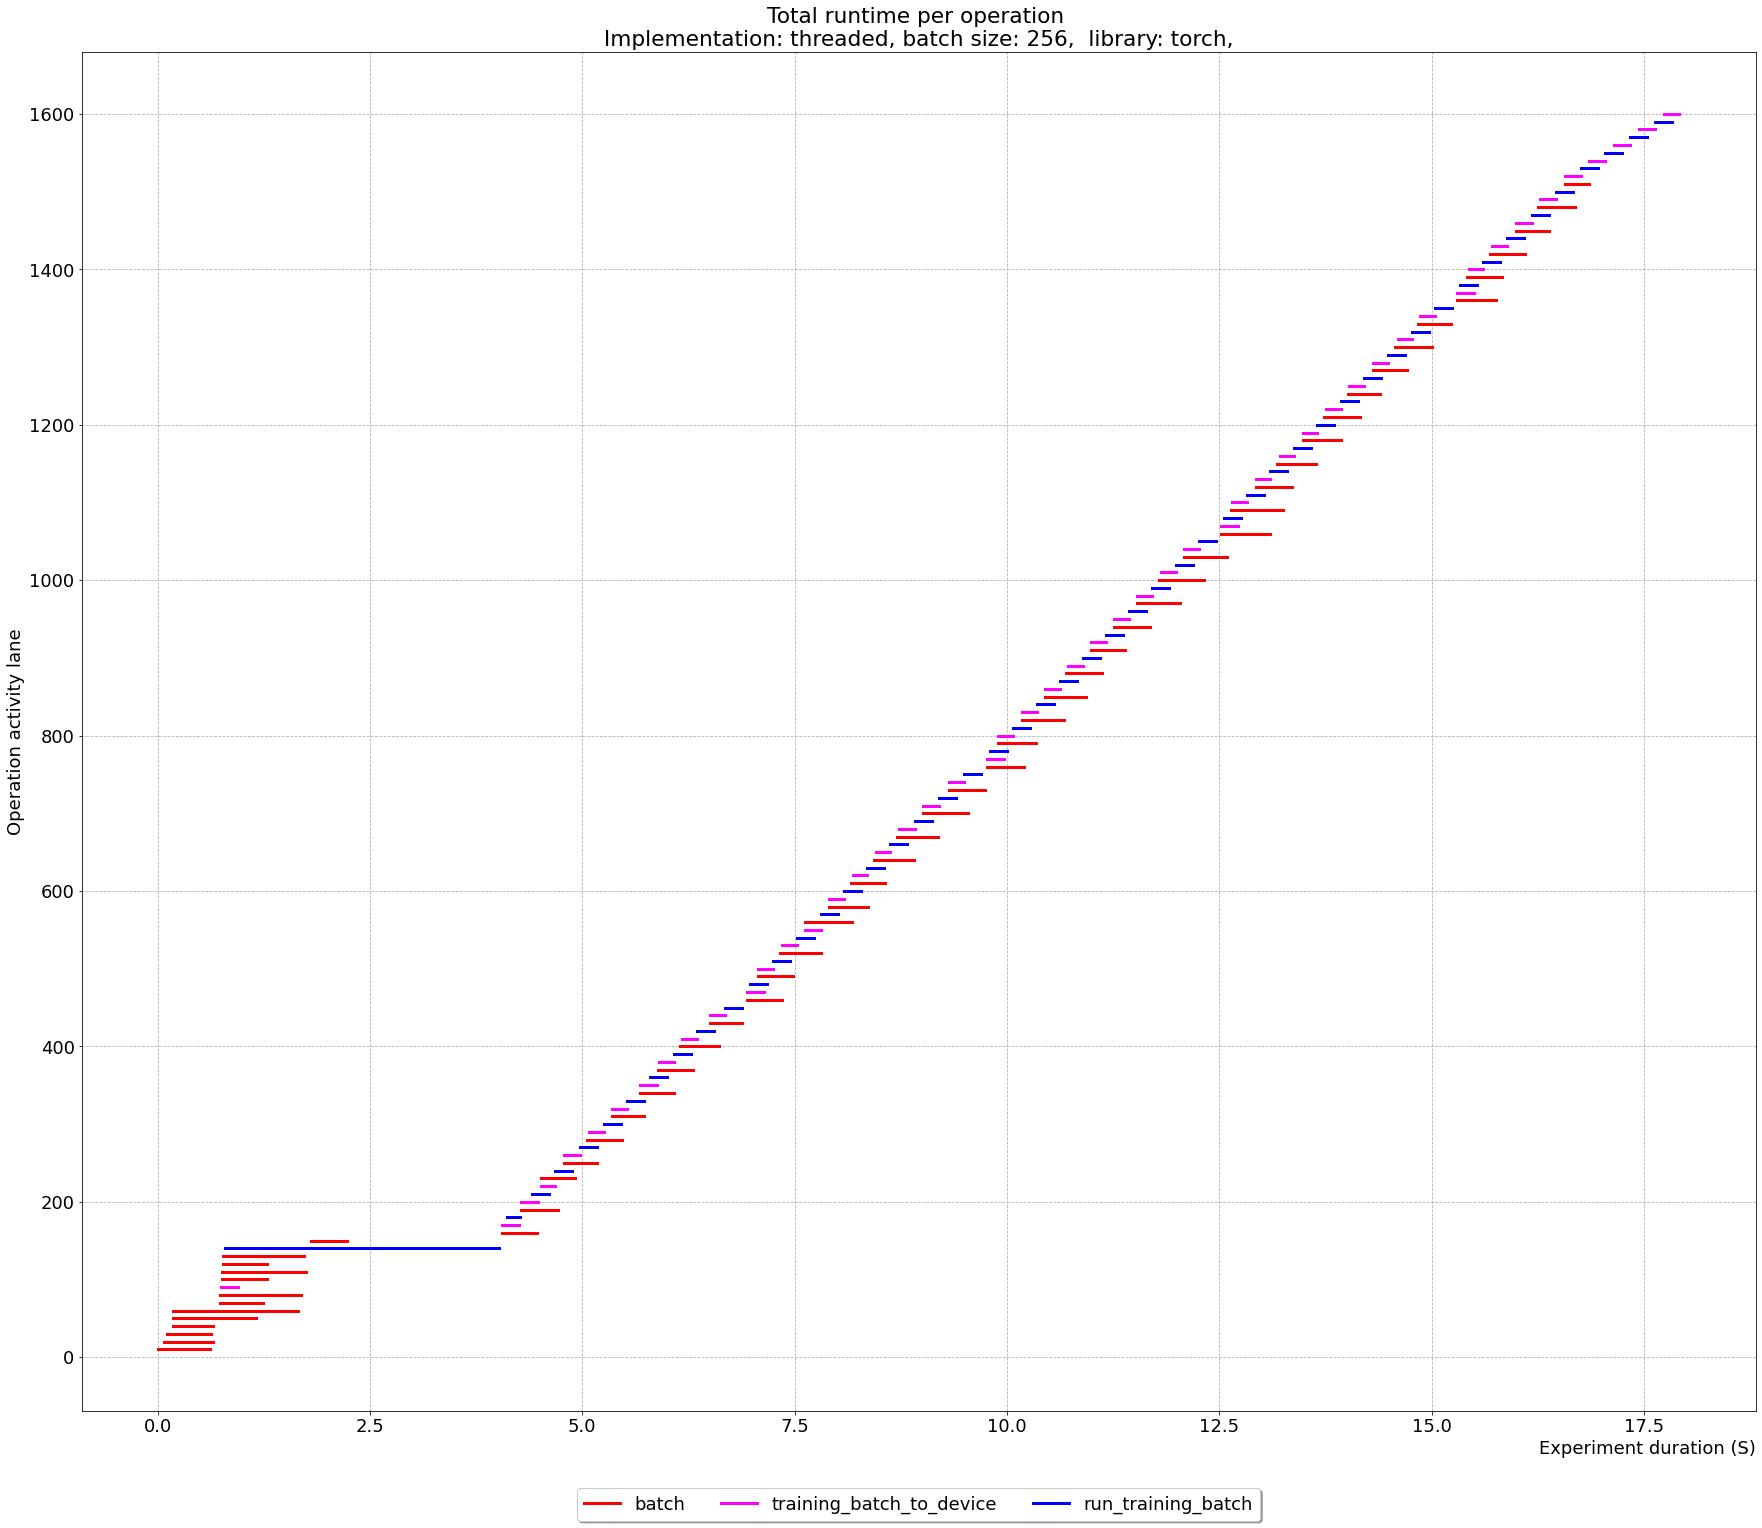

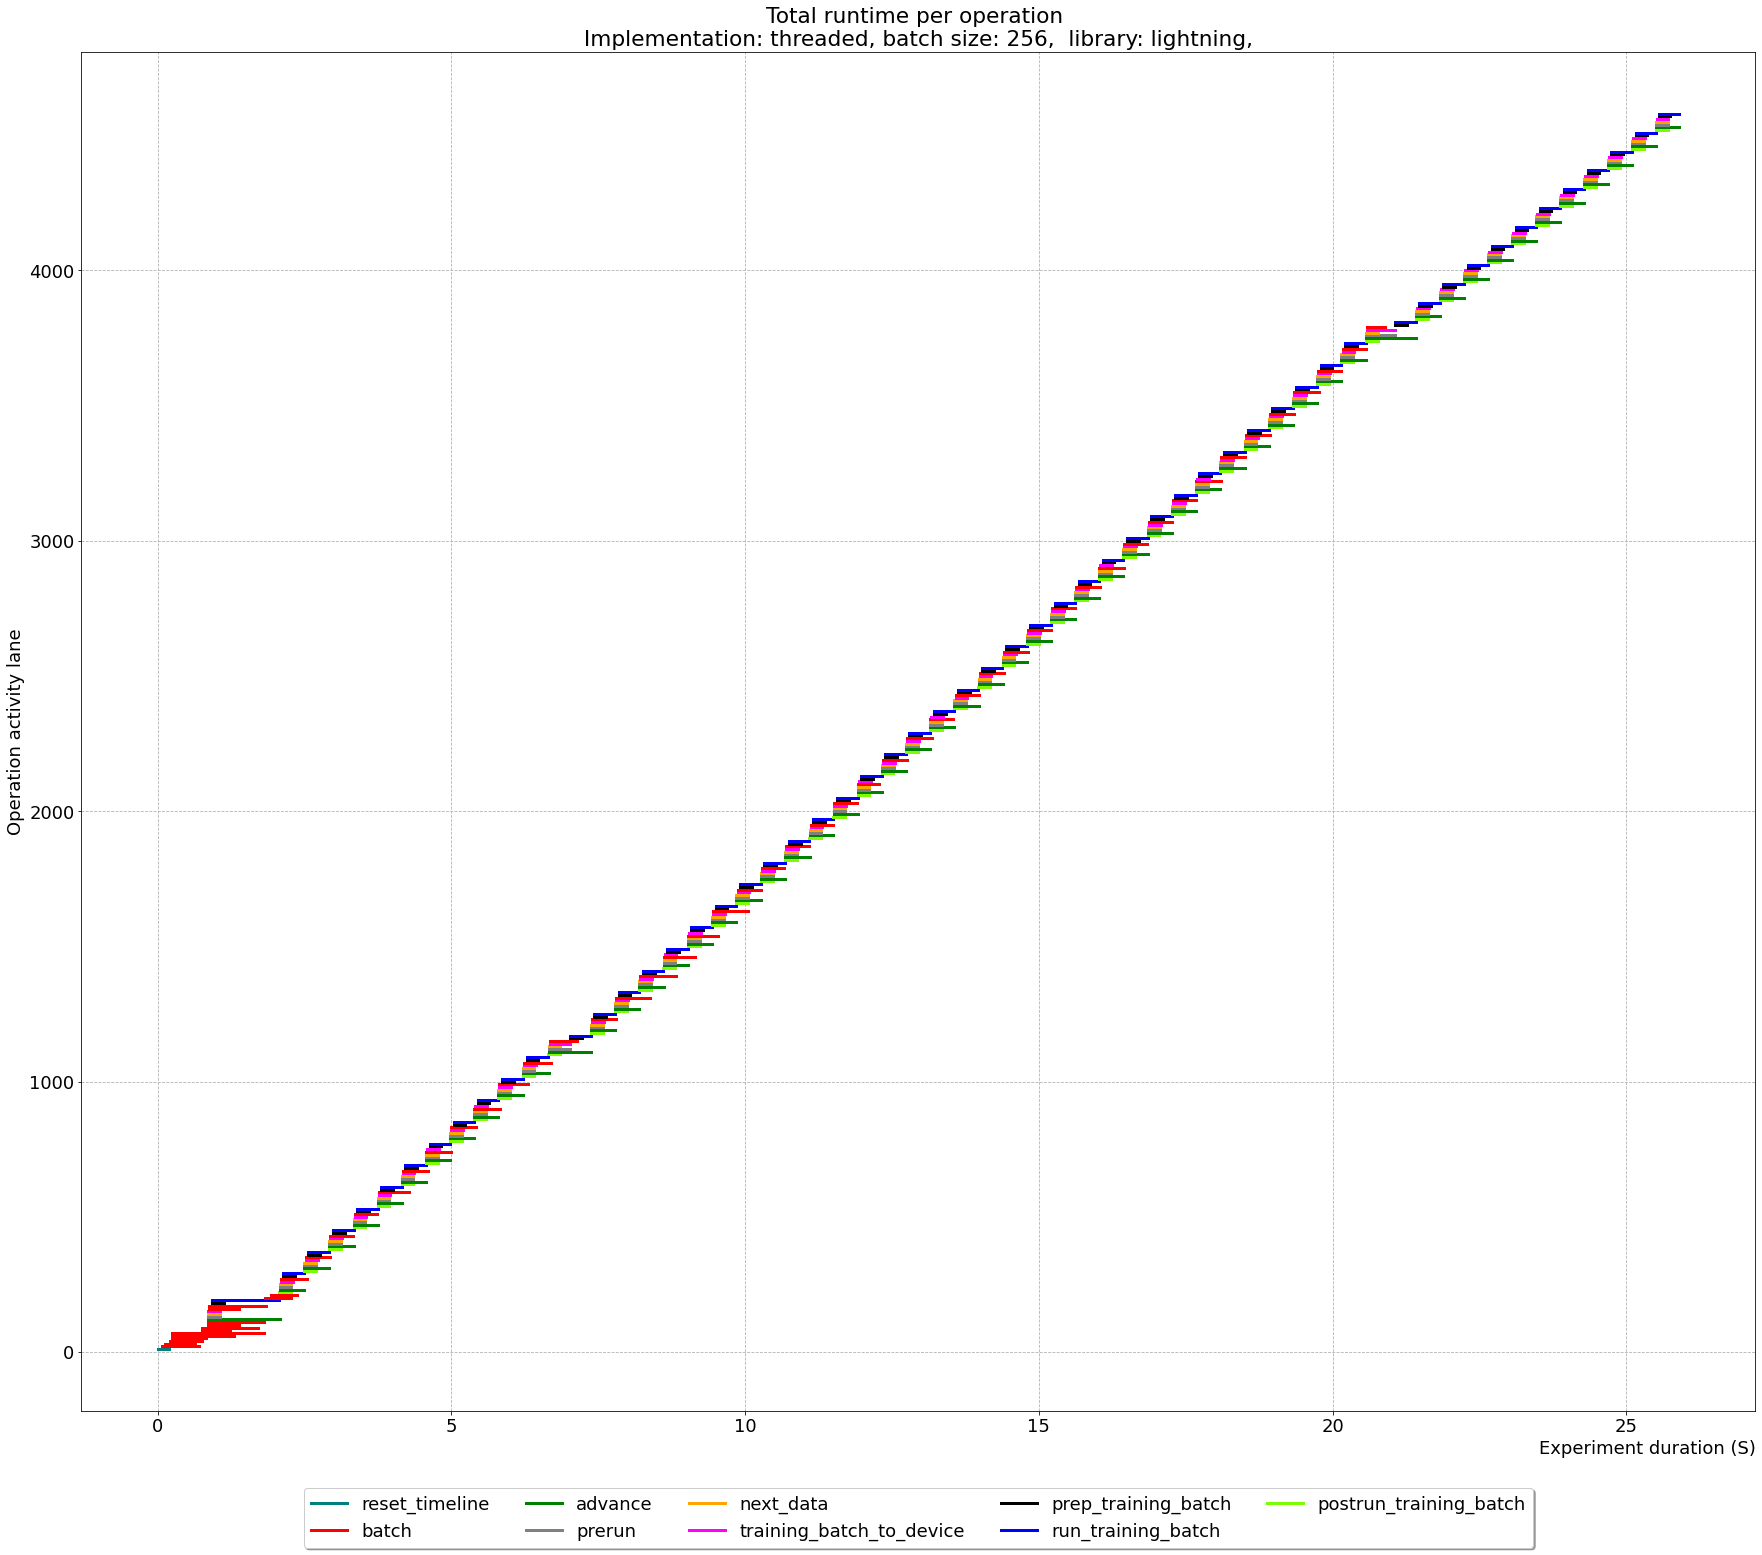

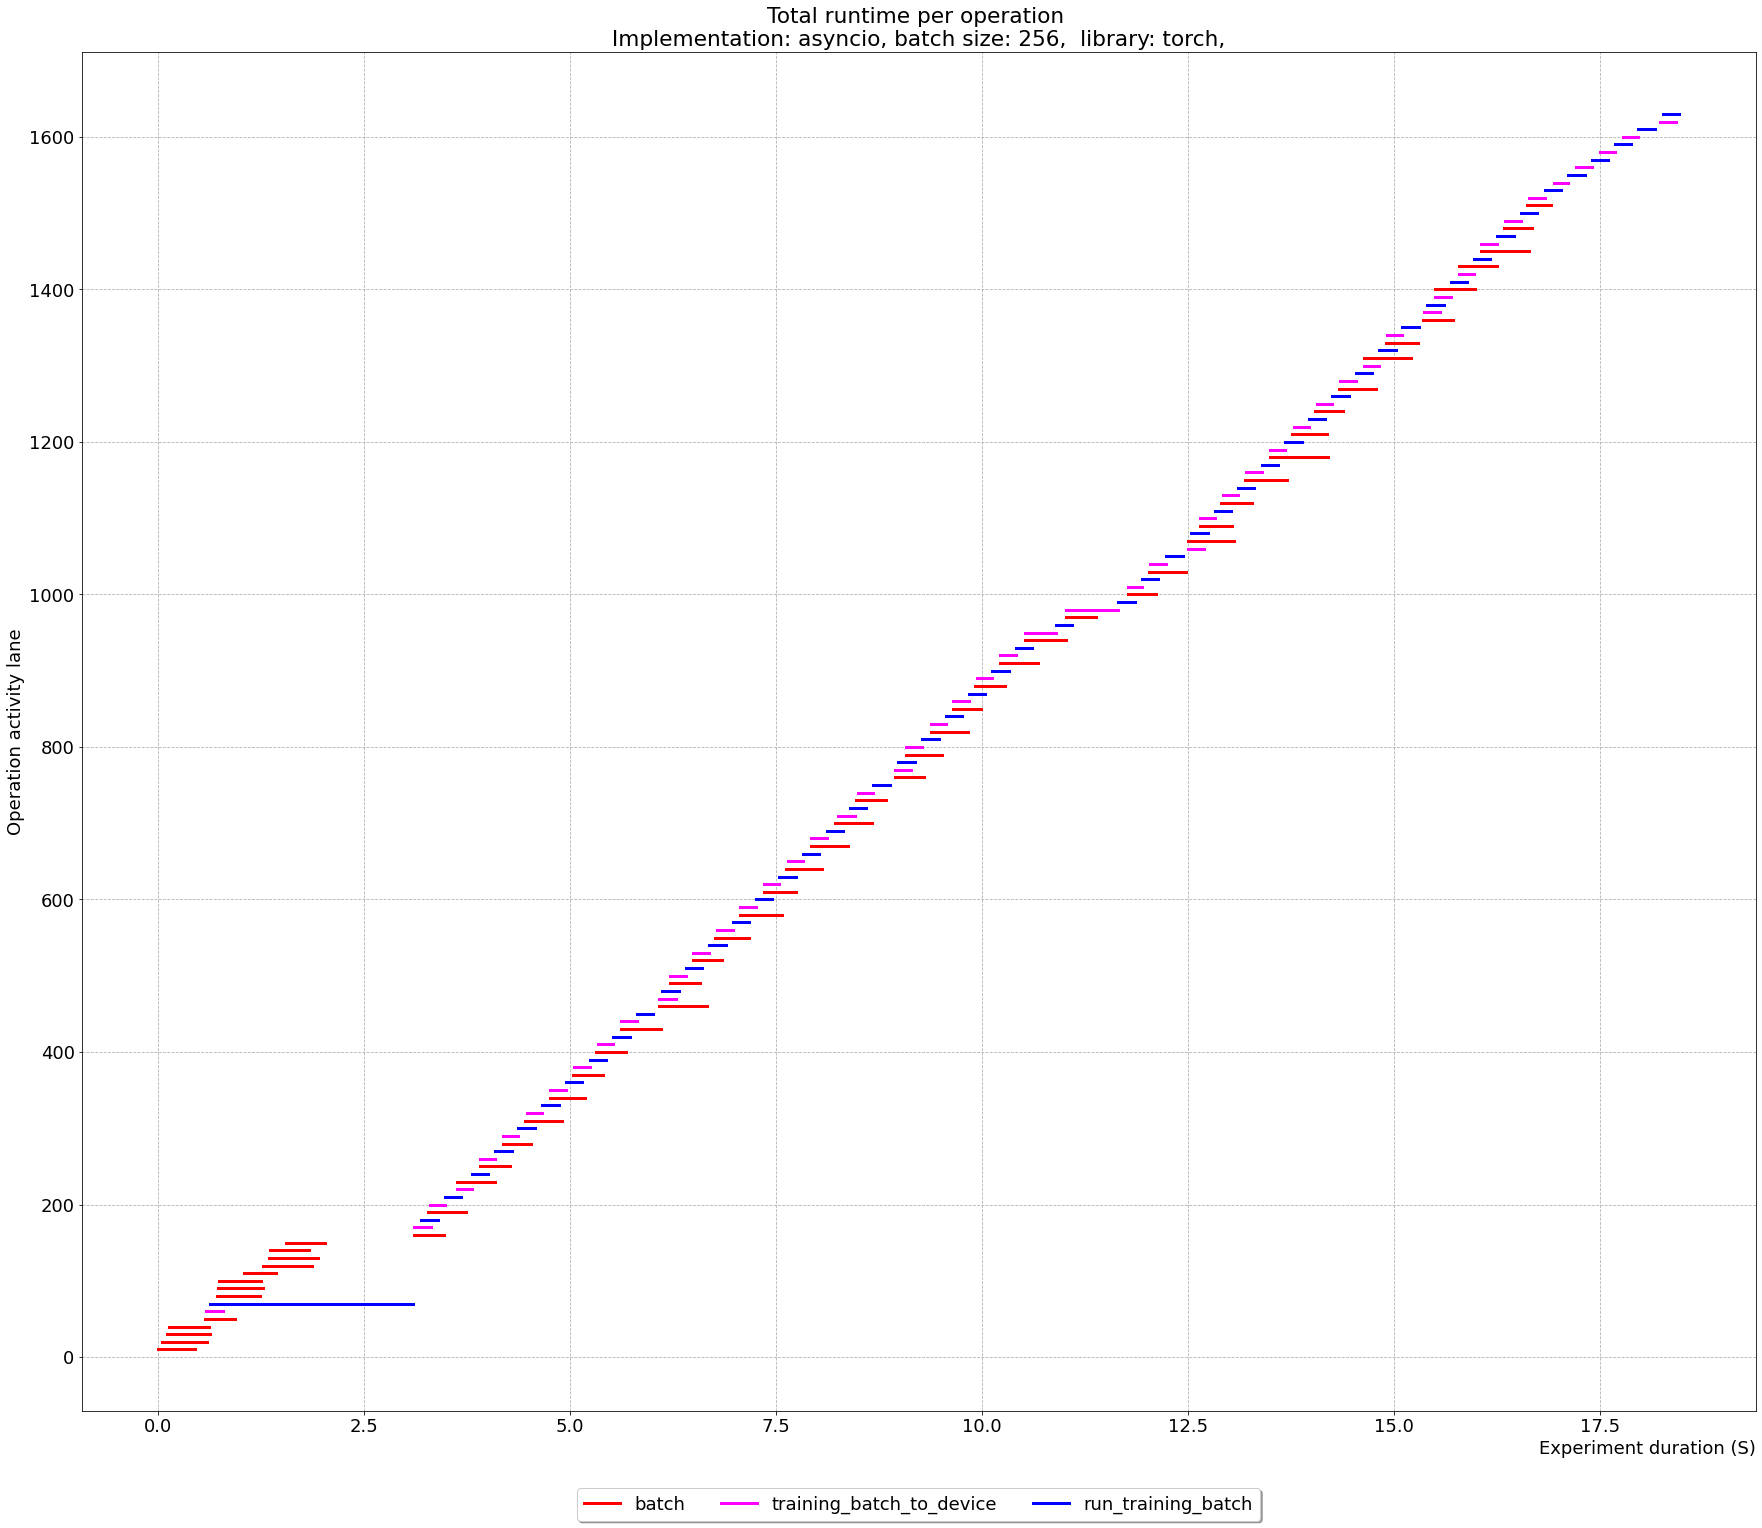

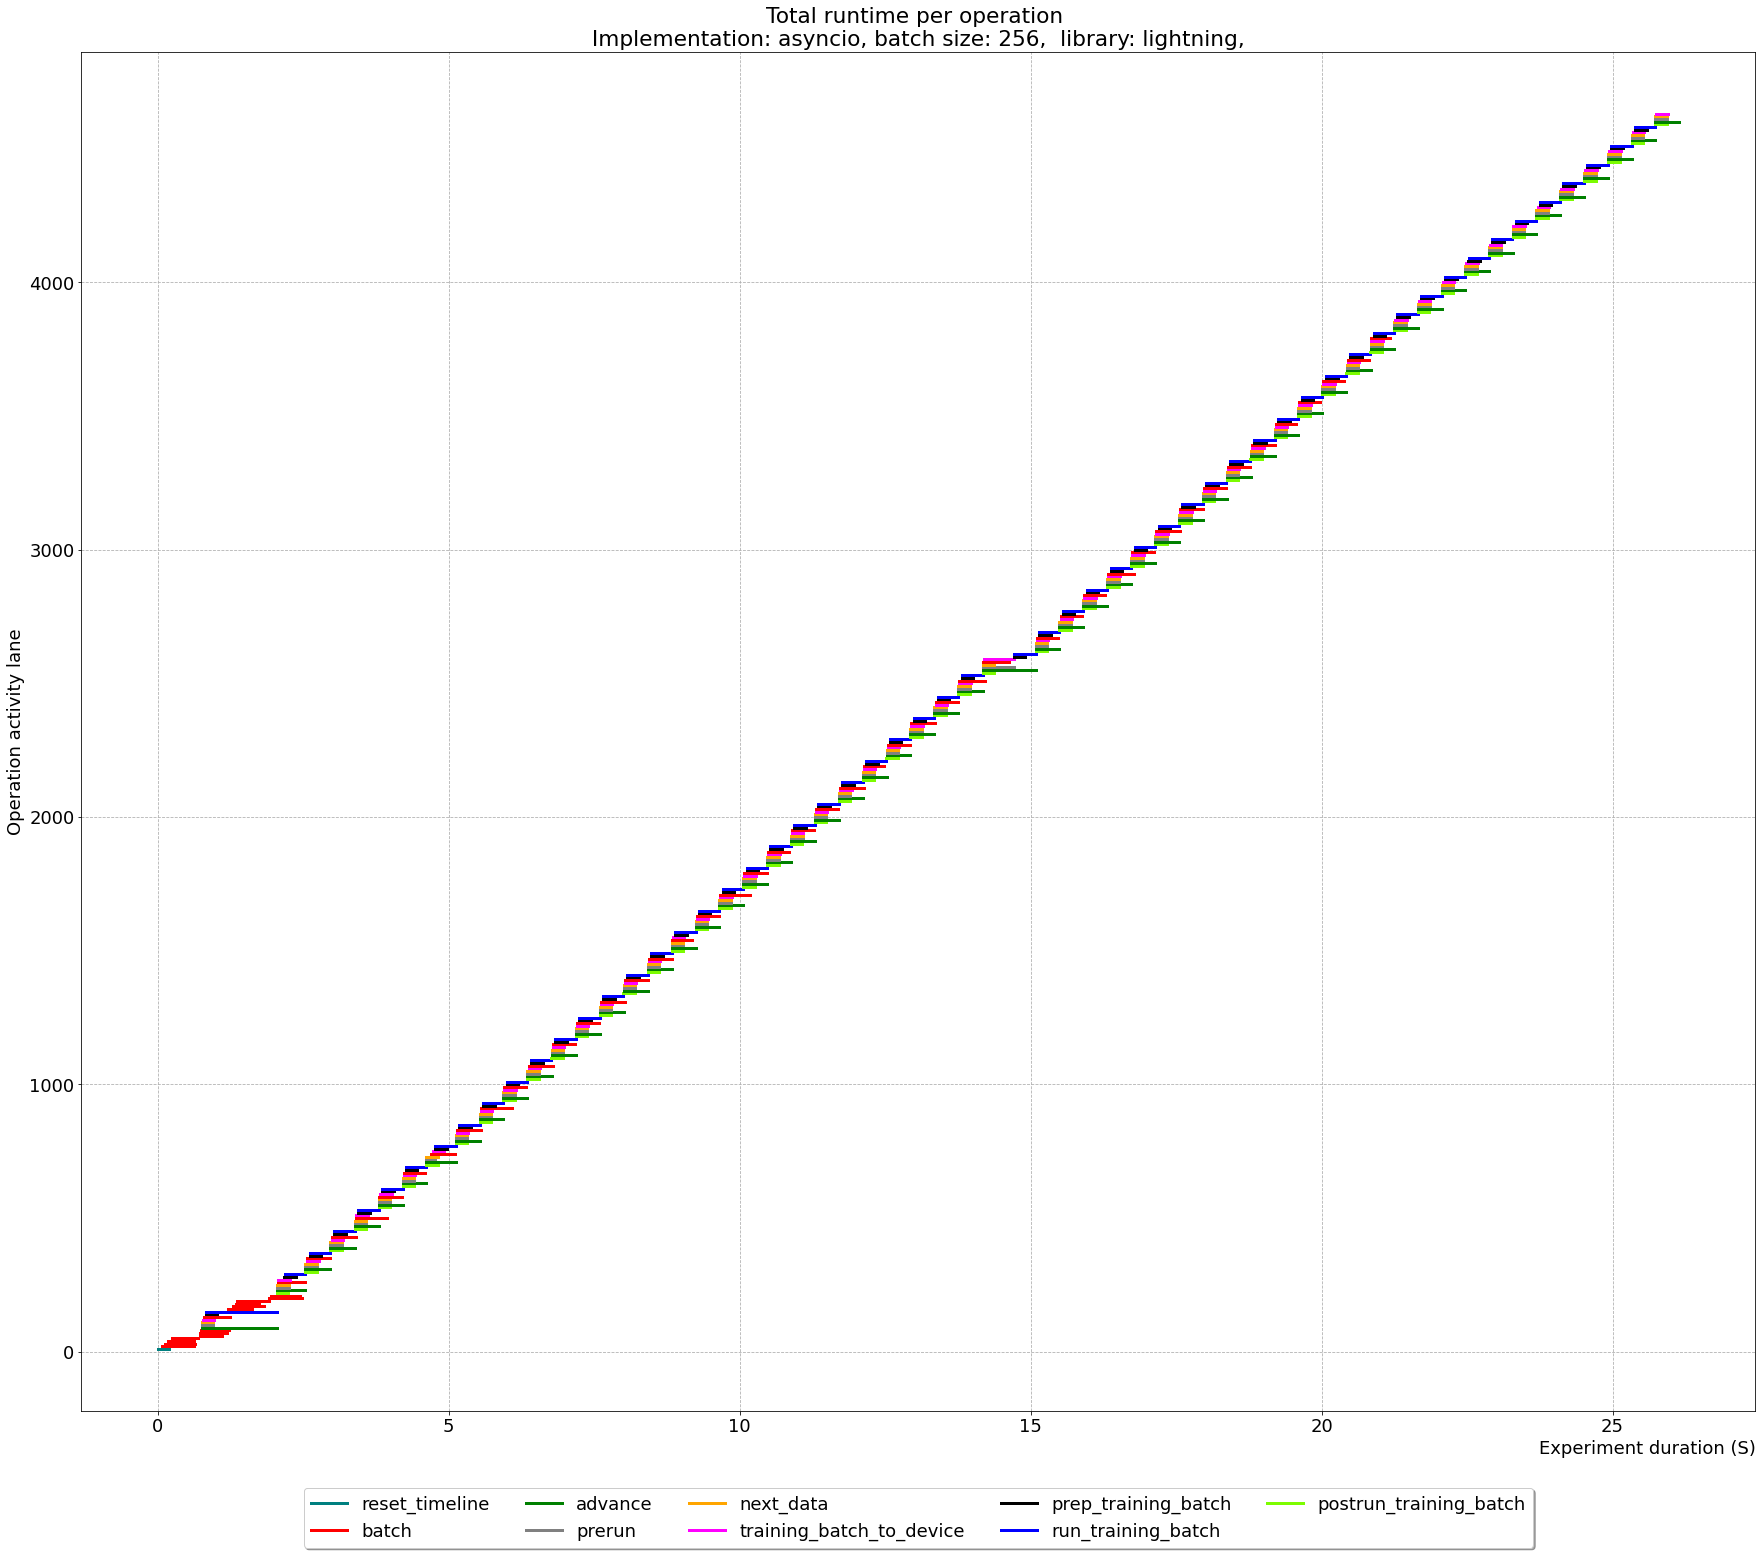

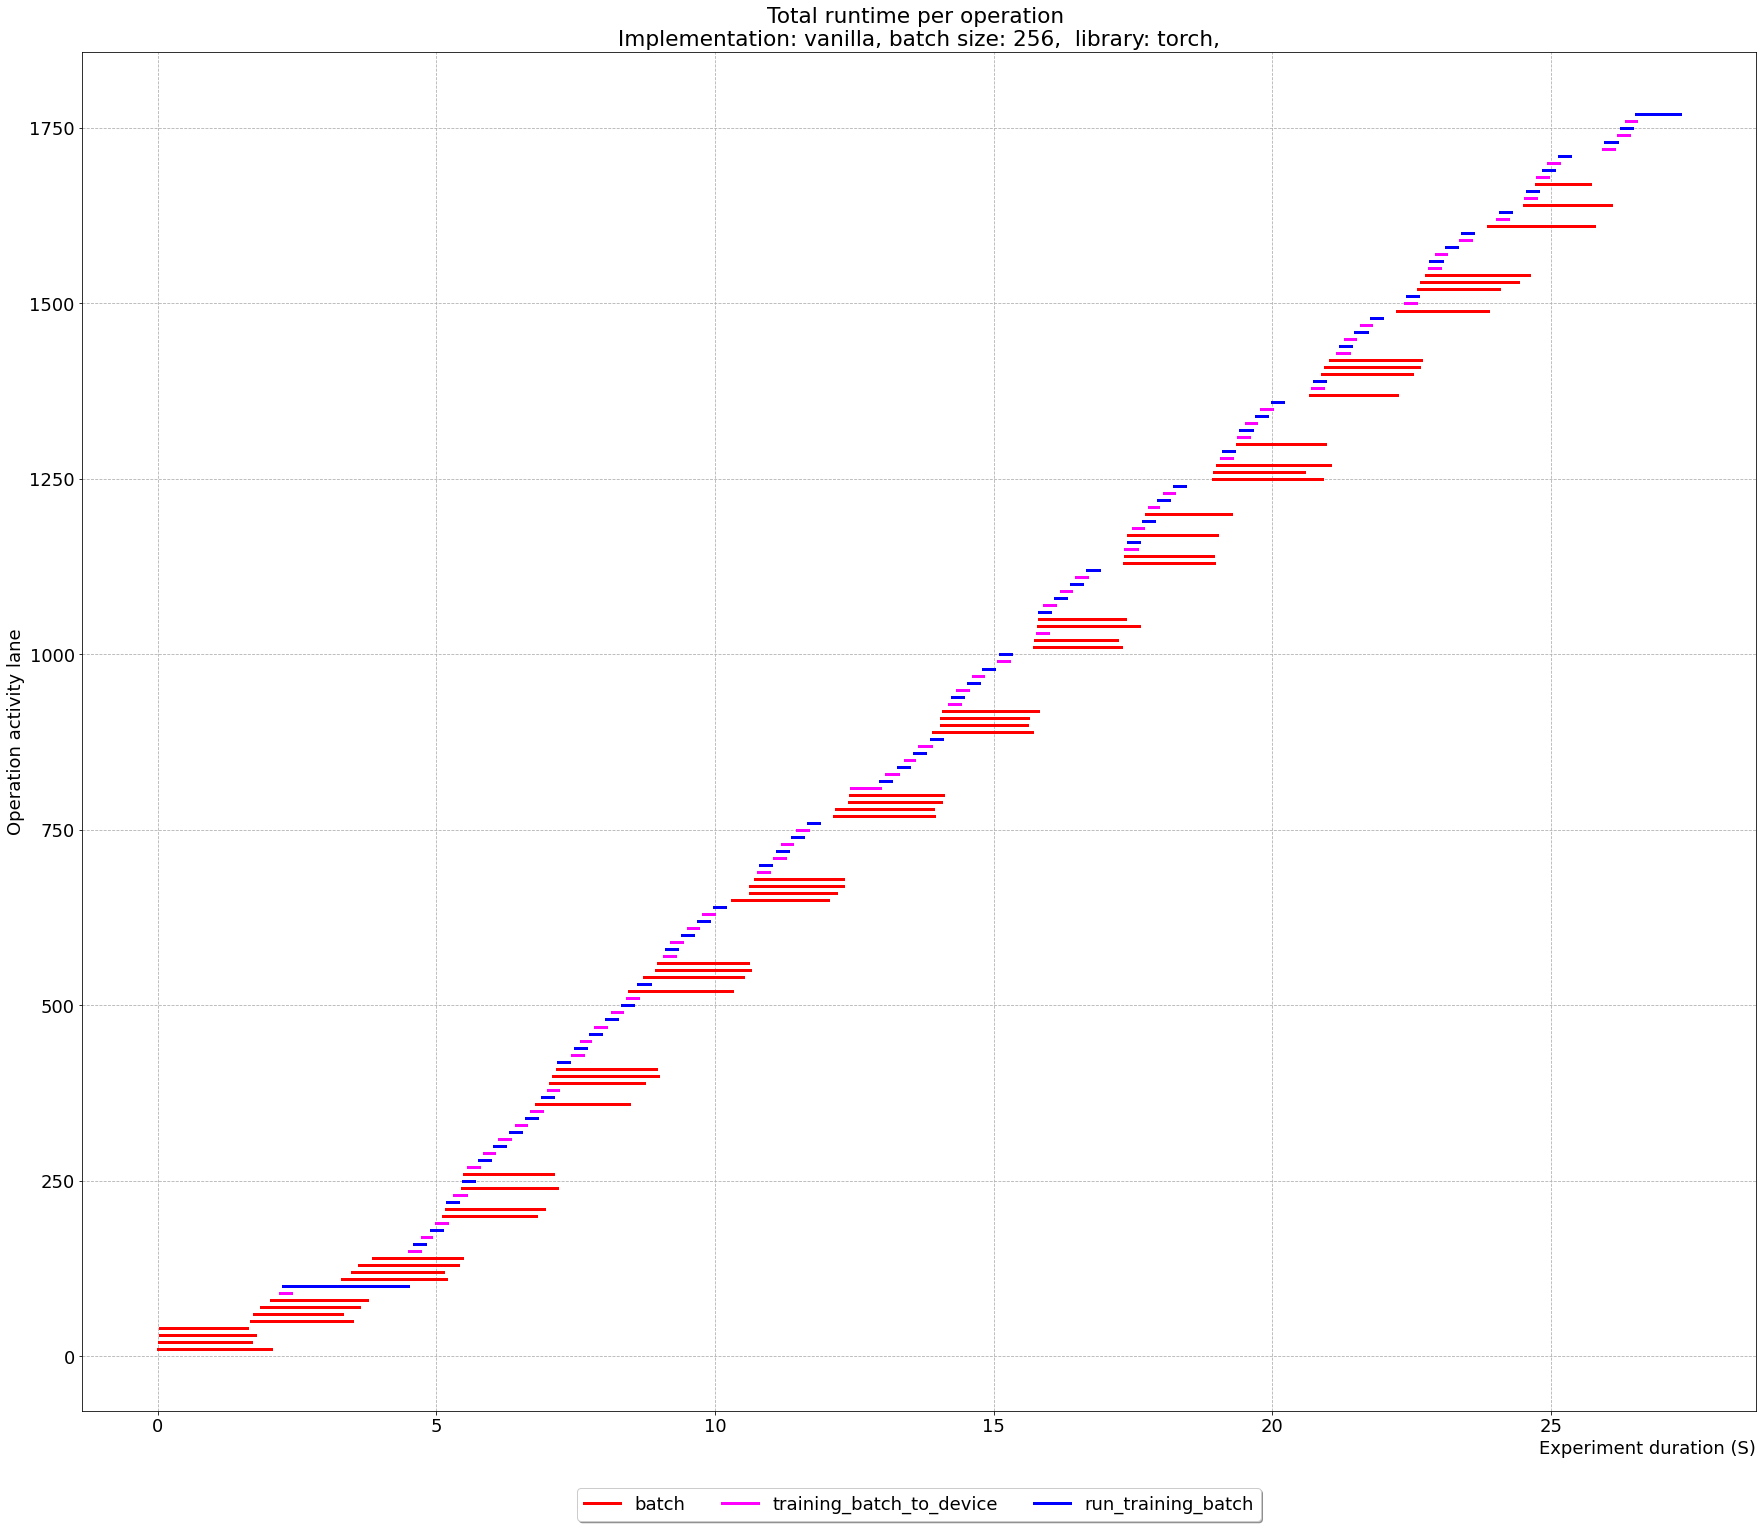

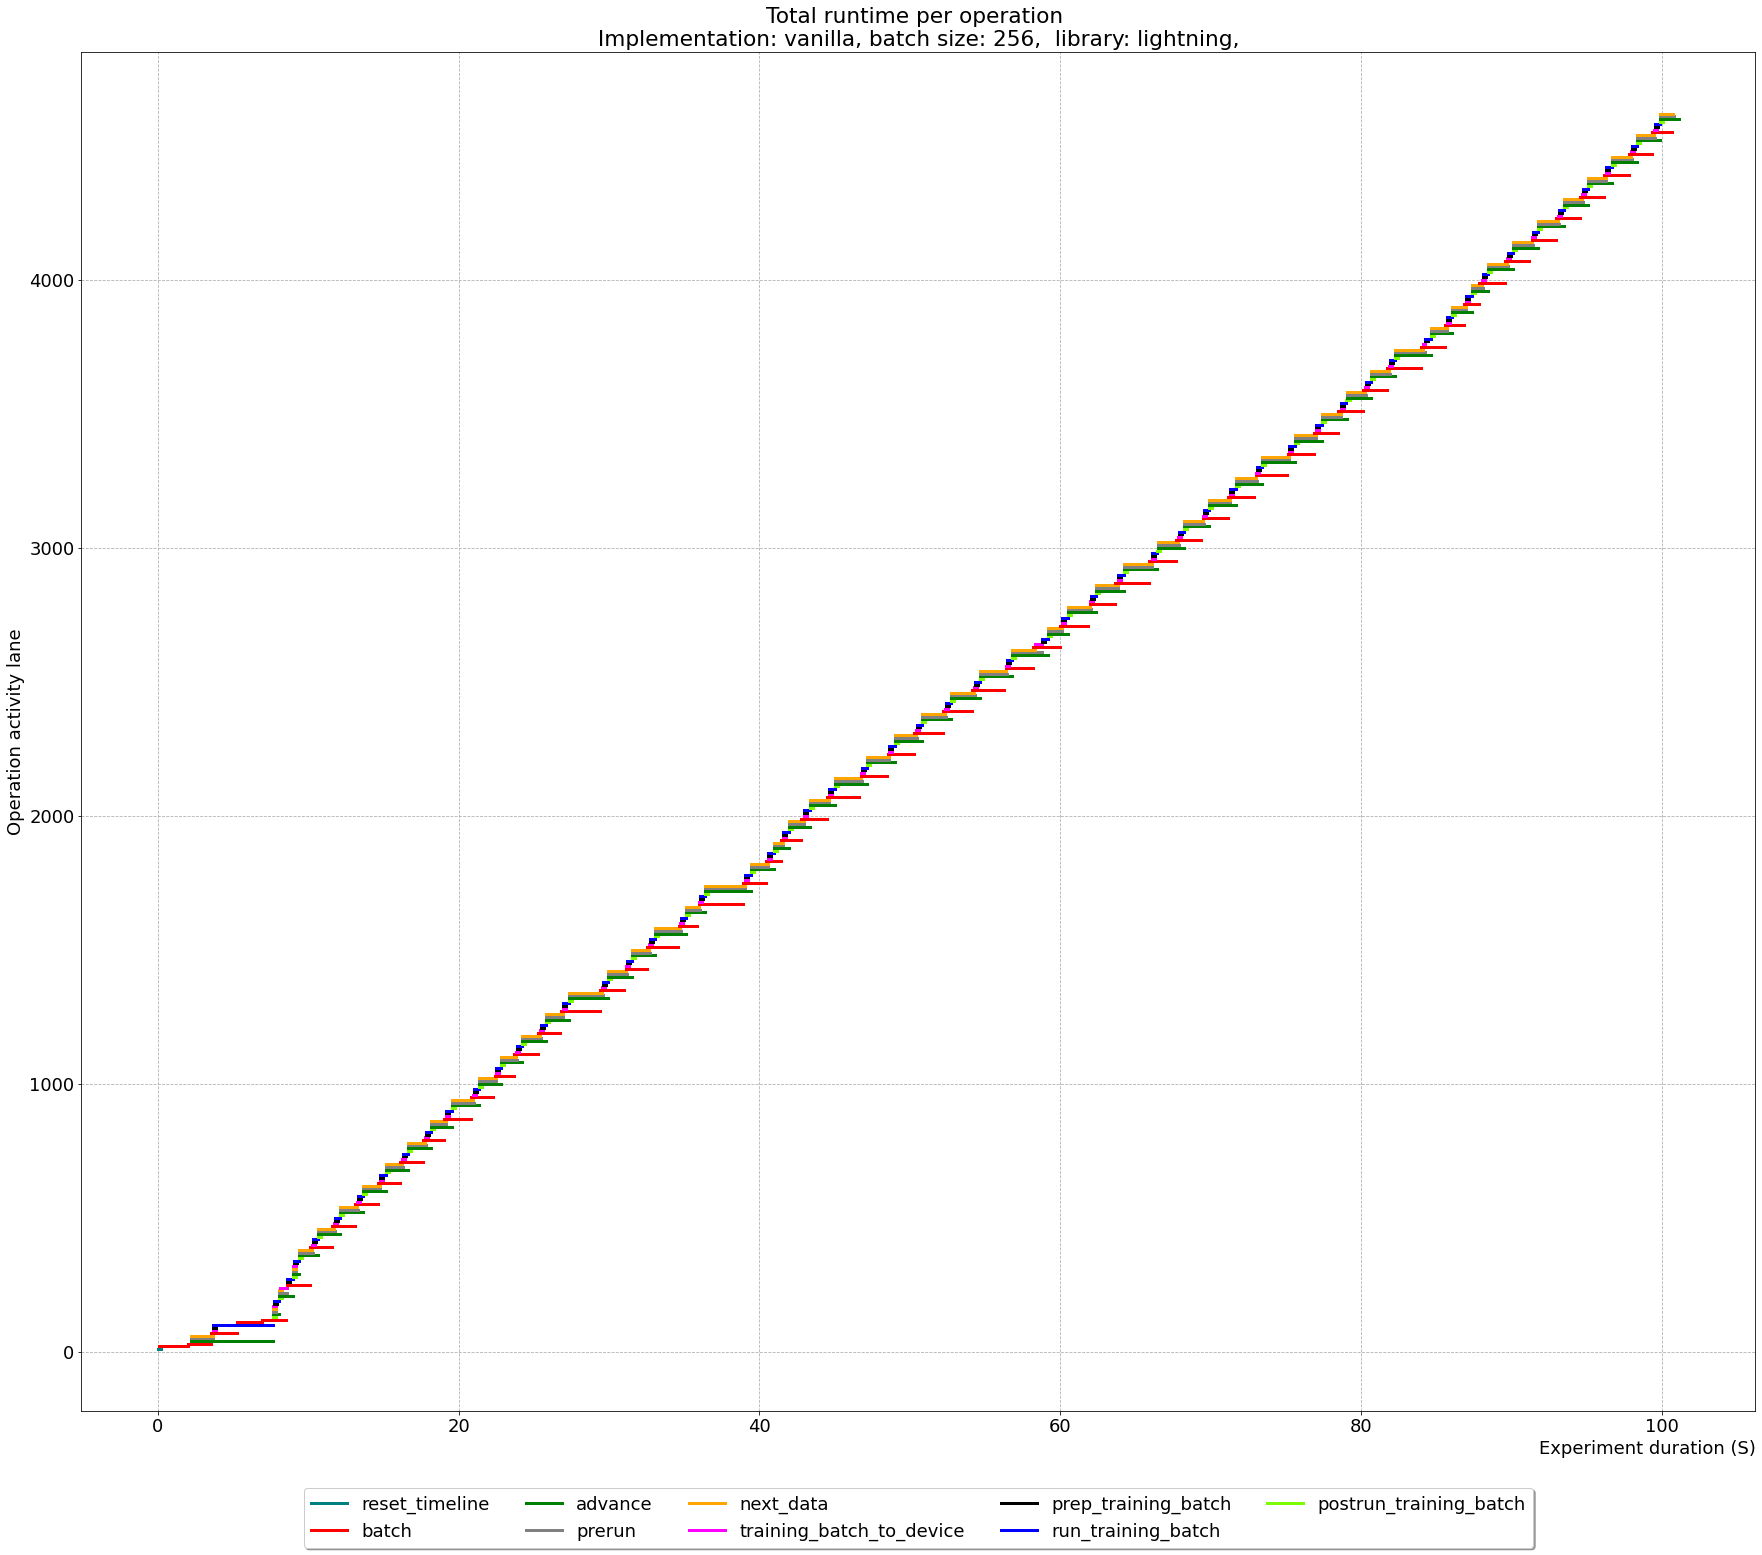

In [8]:
unique_runs_scratch, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_scratch)
returns_scratch = []

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False)
    result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, False, True, 2)
    result["run"]=run
    returns_scratch.append(result)

### Result tables
Print throughput in loaded images per second, and function duration in seconds, for S3 and Scratch

In [9]:
df_full_s3 = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
results_s3 = pd.DataFrame.from_records(data=returns_s3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.40it/s]


In [10]:
r = get_throughput(results_s3, "s3", df_full_s3, unique_runs_s3, output_base_folder)
r

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput,dl_MB,imgs,Mbits/s,MB/s
0,363.797699,0,0,0,0,threaded,1,torch,8246.341317,4239.167614,300000,93.220328,11.652541
1,370.618723,0,0,0,0,threaded,1,lightning,8094.572159,4158.334337,300000,89.759833,11.219979
2,405.899956,0,0,0,0,asyncio,1,torch,7390.983802,4437.903277,300000,87.467923,10.933490
3,399.906597,0,0,0,0,asyncio,1,lightning,7501.751708,4437.903277,300000,88.778796,11.097349
4,4027.708950,0,0,0,0,vanilla,1,torch,744.840314,4437.903277,300000,8.814745,1.101843
5,17084.033858,0,0,0,0,vanilla,1,lightning,175.602555,4437.903277,300000,2.078152,0.259769


In [11]:
df_full_scratch = extract_pandas(output_base_folder, folder_filter=scratch_folder_filter)
results_scratch = pd.DataFrame.from_records(data=returns_scratch)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:20<00:00, 10.79it/s]


In [12]:
r = get_throughput(results_scratch, "scratch", df_full_scratch, unique_runs_scratch, output_base_folder)
r

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput,dl_MB,imgs,Mbits/s,MB/s
0,177.774476,0,0,0,0,threaded,1,torch,16875.313412,4911.124338,300000,221.004700,27.625587
1,258.012324,0,0,0,0,threaded,1,lightning,11627.351564,4914.430514,300000,152.378164,19.047270
2,183.132120,0,0,0,0,asyncio,1,torch,16381.615643,4433.783650,300000,193.686772,24.210847
3,257.864145,0,0,0,0,asyncio,1,lightning,11634.033127,4433.783650,300000,137.554096,17.194262
4,273.071321,0,0,0,0,vanilla,1,torch,10986.140869,4433.783650,300000,129.893791,16.236724
5,1006.092587,0,0,0,0,vanilla,1,lightning,2981.832923,4433.783650,300000,35.255472,4.406934
